In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import division

import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
# from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)


import types
import uuid
import math
import tensorflow as tf
from scipy.misc import logsumexp
# from baselines import deepq
# import baselines.common.tf_util as U

from utils.min_norm_solvers_numpy import MinNormSolver, gradient_normalizers


from envs.environment_visualization_utils import plot_values, plot_mars, plot_reward_map, plot_texture_map, plot_tile_map
from envs.environment_setup_utils import get_mdp
from utils.tf_utils import save_tf_vars, load_tf_vars, os_setup
from utils.soft_q_learning import tabsoftq_learn_Qs, tabsoftq_gen_pol, generate_demonstrations, vectorize_rollouts
from utils.data_utils import initialize_data_files, load_data
from utils.model_setup import create_tf_model
from utils.learning_utils import generate_constraints, nn_vectorize_rollouts, get_rollout_indexes, sample_batch
from envs.environment_utils import featurize_states


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Environment Setup

In [2]:
os_setup()
data_dir = os.path.join('data', '1.1')
mdp = get_mdp(0)

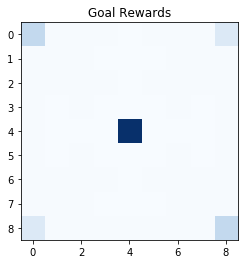

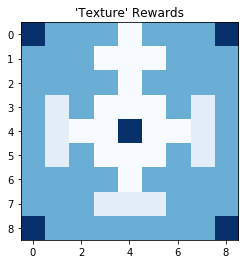

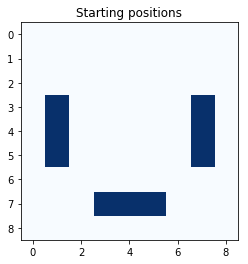

In [3]:
#visualization demos

plot_reward_map(mdp)
plot_texture_map(mdp)
plot_tile_map(mdp)

# Soft-Q Learning for Demonstrations

Sanity check (env and softq)

[[ 40.54471131  39.3663655   39.3663655   40.54471131  42.        ]
 [ 39.07270766  35.41521307  34.8190973   36.40304558  37.16907227]
 [ 36.40314427  32.90307833  30.20220223  33.75740667  34.63298705]
 [ 30.91357339   4.05165815   3.68526051  28.65192842  29.41789472]
 [  0.57641625   0.54706149   0.5758945    0.57392227   0.54759595]
 [  3.7437348    3.96301499  30.36436803  29.056446    28.89614962]
 [ 29.77573859  32.07186961  35.60356577  34.21409817  33.87338748]
 [ 34.21766804  34.46794579  38.03256169  36.98679704  36.1809336 ]
 [ 37.60784024  37.60784024  40.62309336  40.62309336  39.69200454]
 [ 36.40304558  34.8190973   35.41521307  39.07270766  37.16907227]
 [ 36.73271275  33.24183656  33.24183656  36.73271275  34.94614296]
 [ 34.47944951  28.03458079   7.051135    31.26707892  32.80547704]
 [  0.64289454   0.63350319   0.61015221   0.63950696   0.61074982]
 [  0.01373914   0.01356404   0.01372329   0.01367599   0.01314153]
 [  0.59431406   0.61706539   0.62620612   0.623

/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


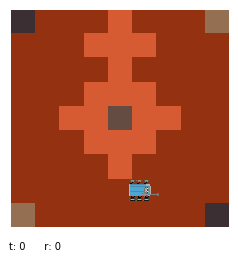

[26.73968225 31.46912266 32.03024937 26.85735377 30.4387369 ]
2
[0.00282309 0.31966437 0.56025853 0.00317562 0.11407839]
(5, 7) b'S'
(6, 7) b'F'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


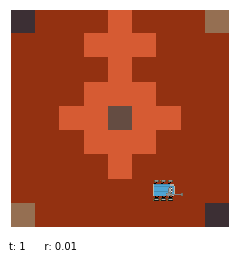

[30.90552702 34.24887786 34.47945207 31.01639814 32.80547946]
2
[0.01374137 0.38907102 0.48996606 0.01535256 0.09186899]
(6, 7) b'F'
(7, 7) b'F'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


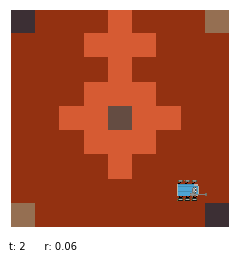

[33.24183875 36.73271301 36.73271301 33.24183875 34.94614321]
2
[0.01367488 0.4487359  0.4487359  0.01367488 0.07517846]
(7, 7) b'F'
(8, 7) b'F'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


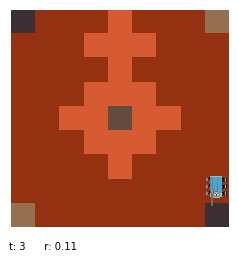

[35.4152133  39.07270768 36.40304561 34.81909753 37.1690723 ]
1
[0.02050134 0.79471584 0.05505444 0.01129516 0.11843322]
(8, 7) b'F'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


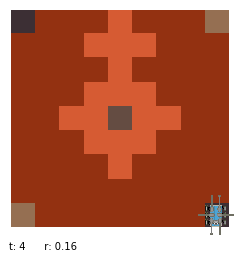

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


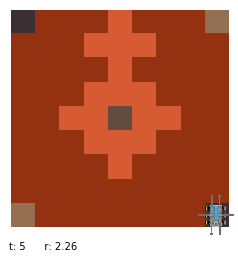

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


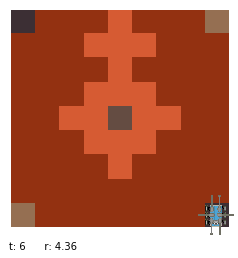

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


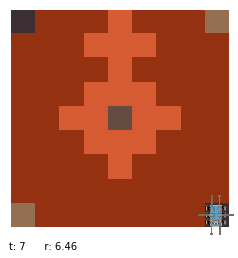

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


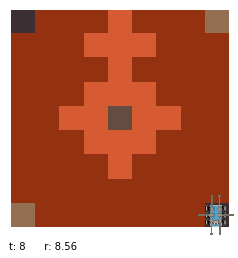

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


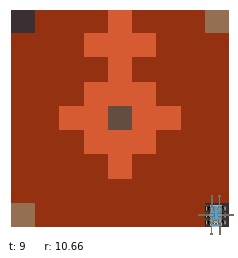

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


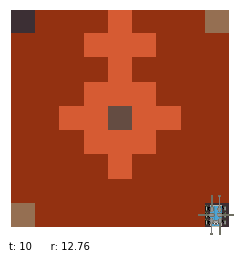

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


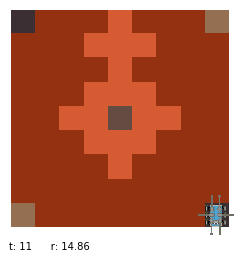

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


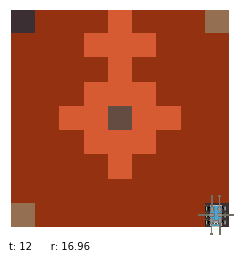

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


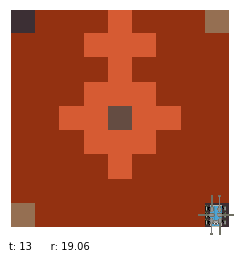

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


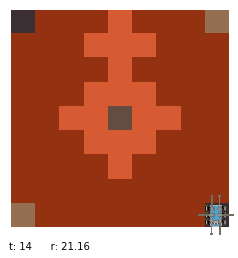

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


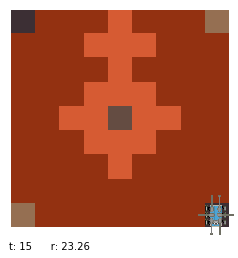

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


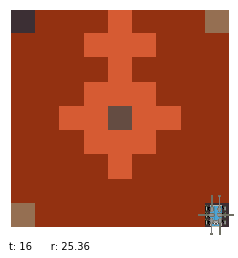

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


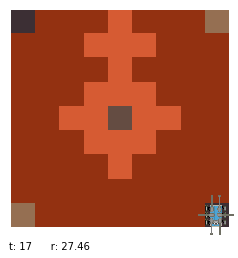

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


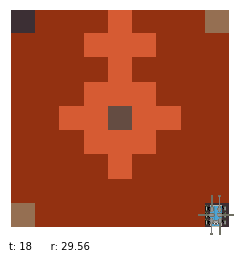

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


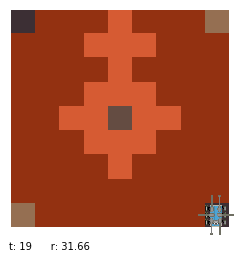

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


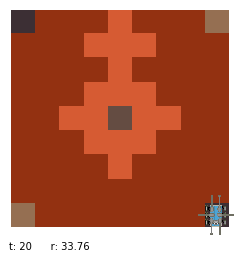

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


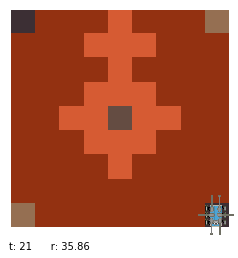

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


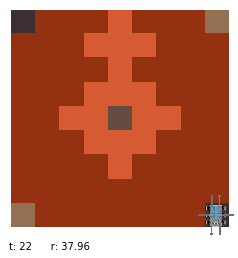

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


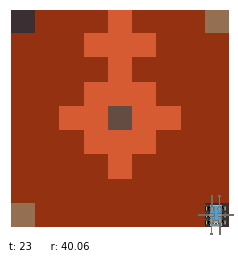

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


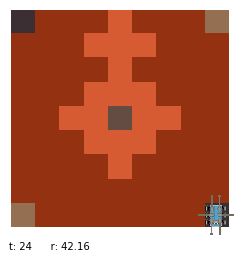

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


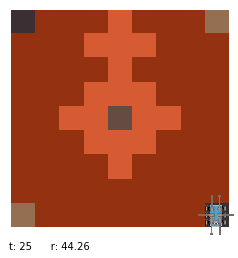

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


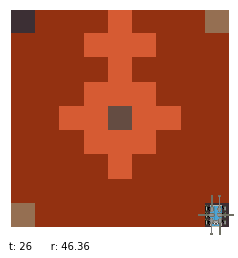

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


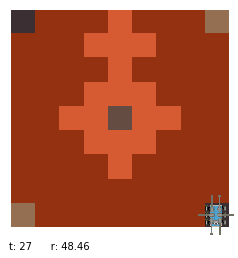

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


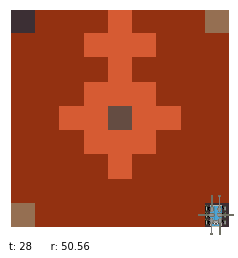

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


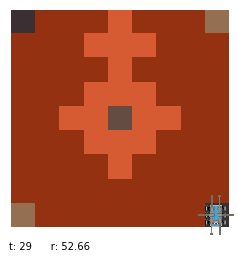

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


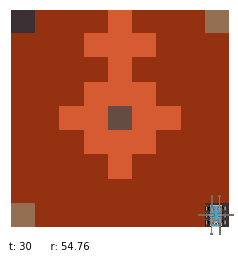

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


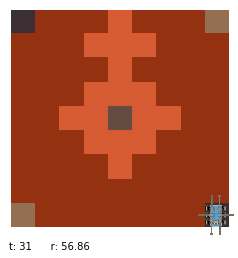

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


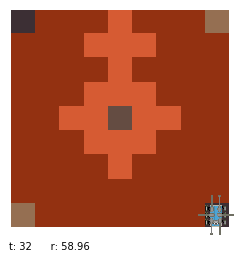

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


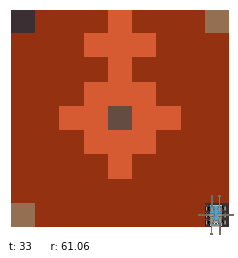

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


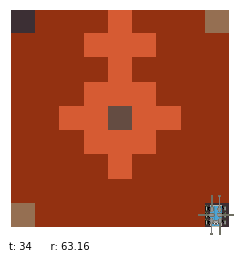

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


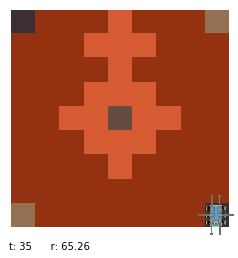

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


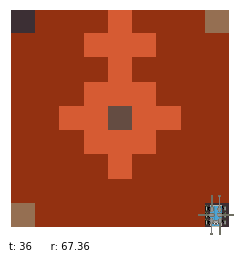

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


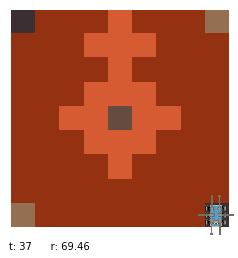

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


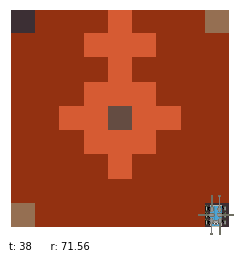

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/michael_dennis/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


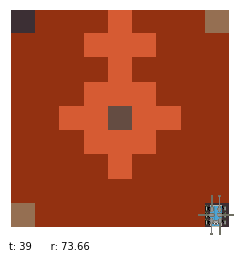

[39.36636552 40.54471132 40.54471132 39.36636552 42.        ]
4
[0.04459851 0.14490033 0.14490033 0.04459851 0.62100232]
(8, 8) b'2'
(8, 8) b'2'


In [4]:
temp_Q = tabsoftq_learn_Qs(mdp, gamma=0.95)
plot_mars(mdp, tabsoftq_gen_pol(temp_Q*50), Qs=temp_Q)


# Model Set Up

In [5]:
gamma = 0.99
alpha = 1e-4
beta1 = 0.9
beta2 = 0.999999
sq_td_err_penalty = 1
trans_penalty = 1
t_err_penalty = 1e0
q_err_penalty = 1e0
constraint_batch_size = 512

q_n_layers = 2
q_layer_size = 2048
q_activation = tf.nn.tanh
q_output_activation = None

invdyn_n_layers = 1
invdyn_layer_size = 256
invdyn_activation = tf.nn.relu
invdyn_output_activation = None


n_act_dim = 5

featurize_acts = lambda a: a
n_dirs = 5

# Boltz-beta determines the "rationality" of the agent being modeled.
# Setting it to higher values corresponds to "pure rationality"
boltz_beta = 50

batch_size=512

In [6]:
###### UNCOMMENT WHEN FIRST RUNNING THIS NOTEBOOK #######
# initialize_data_files(data_dir)
im_scope, q_scope, invsas_scope, invadt_scope = load_data(data_dir)
sess = tf.Session()
compute_batch_loss, idl_train, frank_wolfe_train = create_tf_model(sess, mdp, q_scope, invsas_scope, invadt_scope,
                                               gamma, alpha, beta1, beta2, sq_td_err_penalty, trans_penalty,
                                               t_err_penalty, q_err_penalty, constraint_batch_size,
                                               q_n_layers, q_activation, q_output_activation, invdyn_n_layers,
                                               invdyn_layer_size, invdyn_output_activation, n_act_dim, featurize_acts,
                                               n_dirs, boltz_beta)

# IDL Experiments

## Demo setup

In [7]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False
batch_size = 200
n_demos = 200
demo_time_steps = 40

In [8]:
def clean_demos(sas_obs, max_noops=15):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays, stay_count = set([]), 0
    for i,sas in enumerate(sas_obs):
        sas = tuple(sas)
        if sas[1] == 4:
            stay_count += 1
            if sas in unique_stays:
                if stay_count > max_noops:
                    demo_example_idxes.remove(i)
            else:
                unique_stays.add(sas)
        else:
            stay_count = 0
    return demo_example_idxes

# def sample_batch(size, ids, sas_obs, adt_obs):
#     idxes = random.sample(ids, size)
#     return sas_obs[idxes], adt_obs[idxes]

In [9]:
exQs = tabsoftq_learn_Qs(mdp, gamma=gamma)
# The rationality constant used to generate demos could certainly vary from the one used in the model.....
temp_boltz_beta = 50
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs * temp_boltz_beta), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

[[208.44793162 207.18127902 207.18127902 208.44793162 210.        ]
 [206.99287621 202.96944566 202.29977102 204.1002877  204.97294744]
 [204.07436214 198.44322909 185.17373676 199.58882701 202.08361852]
 [183.12845022  36.32702745  34.95093068 179.15448334 181.34716572]
 [ 16.97620454  16.79653099  16.97556524  16.98153444  16.8117191 ]
 [ 35.01525282  36.16339701 182.48269324 179.65517111 180.70786631]
 [184.64716479 197.4379815  203.17779759 200.12479717 201.19601961]
 [201.59176201 201.87644087 205.87995687 204.75358624 203.87115731]
 [205.32904157 205.32904157 208.59211573 208.59211573 207.60626319]
 [204.10032334 202.30005617 202.9694813  206.99287621 204.97294744]
 [204.45205845 200.28494297 200.28491827 204.45205492 202.45760476]
 [201.73133557 178.50494151  54.19774545 183.716717   199.76402222]
 [ 18.17234051  18.13088664  17.9742501   18.15392365  17.99061711]
 [  1.63997683   1.63624259   1.63988324   1.63879793   1.62360982]
 [ 17.88075551  18.03661872  18.077807    18.059

In [10]:
# Ensure bad areas have not been visited in exes (this is unique to this experiment)
demos = []
while len(demos) < n_demos:
    new_demo = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs, beta=50), 1, demo_time_steps)[0]
    more_sas, more_adt = list(zip(*new_demo))
    if len(set([adt[2] for adt in more_adt])) == 1:
        demos += [new_demo]
        
sas_obs, adt_obs = vectorize_rollouts(demos)

In [11]:
good_indexes = clean_demos(sas_obs)
sas_obs, adt_obs = sas_obs[good_indexes], adt_obs[good_indexes]
constraints = generate_constraints(mdp)
nn_rollouts = nn_vectorize_rollouts(mdp, sas_obs, adt_obs)
train_idxes, val_idxes = get_rollout_indexes(sas_obs)
val_demo_batch = sample_batch(nn_rollouts, val_idxes)

In [12]:
# True q-vals for debugging and comparison purposes
Qs = tabsoftq_learn_Qs(mdp, gamma=gamma)
sa = np.transpose([np.tile(np.arange(mdp.num_states), mdp.num_actions), np.repeat(np.arange(mdp.num_actions), mdp.num_states)])
states, acts = sa[:,0], sa[:,1]
true_qs = Qs[states,acts]

# Preprocessing for training update visualizations
tts = np.arange(2)
acts = np.arange(mdp.num_actions) 
adt_samples = np.transpose([np.tile(tts, len(acts)), np.repeat(acts, len(tts))])
adt_samples = adt_samples[adt_samples[:,0].argsort()]
states = featurize_states(mdp, np.arange(mdp.num_states))

# Optional preloading of q-fn or dynamics models
# q_net_path = os.path.join(data_dir, 'true_q_16384.tf')
# save_tf_vars(sess, q_scope, q_net_path)
# load_tf_vars(sess, q_scope, q_net_path)

#invadt_path = os.path.join(data_dir, 'adt_fw_t.tf')
#load_tf_vars(sess, invadt_scope, invadt_path)

[[208.44793162 207.18127902 207.18127902 208.44793162 210.        ]
 [206.99287621 202.96944566 202.29977102 204.1002877  204.97294744]
 [204.07436214 198.44322909 185.17373676 199.58882701 202.08361852]
 [183.12845022  36.32702745  34.95093068 179.15448334 181.34716572]
 [ 16.97620454  16.79653099  16.97556524  16.98153444  16.8117191 ]
 [ 35.01525282  36.16339701 182.48269324 179.65517111 180.70786631]
 [184.64716479 197.4379815  203.17779759 200.12479717 201.19601961]
 [201.59176201 201.87644087 205.87995687 204.75358624 203.87115731]
 [205.32904157 205.32904157 208.59211573 208.59211573 207.60626319]
 [204.10032334 202.30005617 202.9694813  206.99287621 204.97294744]
 [204.45205845 200.28494297 200.28491827 204.45205492 202.45760476]
 [201.73133557 178.50494151  54.19774545 183.716717   199.76402222]
 [ 18.17234051  18.13088664  17.9742501   18.15392365  17.99061711]
 [  1.63997683   1.63624259   1.63988324   1.63879793   1.62360982]
 [ 17.88075551  18.03661872  18.077807    18.059

## IDL Training

In [13]:
n_training_iters = 1000000

[('loss', 12027206.0)]


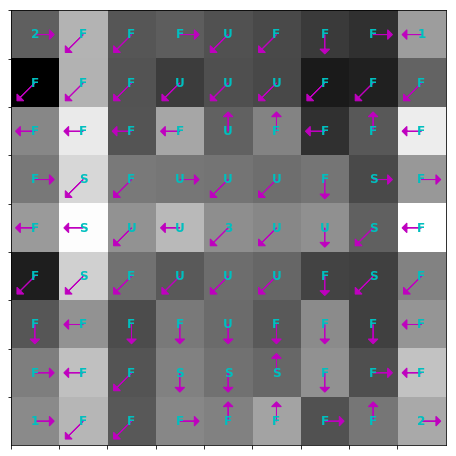

[[0.2        0.2        0.2        0.2        0.2       ]
 [0.19402136 0.23023883 0.1834933  0.18025008 0.21199635]
 [0.18658273 0.262742   0.16688327 0.16103612 0.22275586]
 [0.17783384 0.29716766 0.15042727 0.14259103 0.23198025]
 [0.16797699 0.33309332 0.13437936 0.12512769 0.23942263]
 [0.20867032 0.20302981 0.196713   0.208106   0.18348089]
 [0.21010347 0.22039858 0.18116039 0.19074537 0.19759218]
 [0.20270492 0.24928933 0.16824988 0.17174615 0.20800981]
 [0.19355276 0.28112608 0.1527187  0.1531338  0.2194687 ]
 [0.18388237 0.31679574 0.13653016 0.13471892 0.2280728 ]]


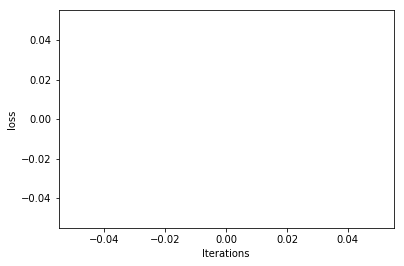

KeyboardInterrupt: 

In [14]:
idl_train(n_training_iters, nn_rollouts, train_idxes, constraints, true_qs, val_demo_batch,
          states, adt_samples, batch_size)

## Frank Wolfe

In [18]:
MAX_ITER = 250
STOP_CRIT = 1e-6
num_tasks = 2

[0.00032768 0.99967232]
[('loss', 6.9739695), ('nall', 0.7474104), ('tde', 4.1352983), ('ntll', 2.0912607)]


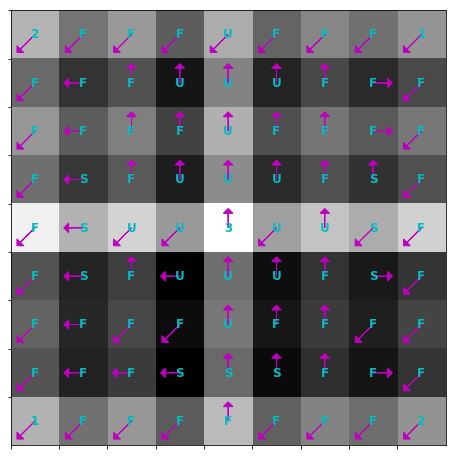

[[0.19999029 0.19998637 0.19991925 0.19994059 0.20016351]
 [0.21405655 0.23704028 0.18384376 0.19252609 0.1725334 ]
 [0.22618893 0.27739245 0.16684759 0.18295203 0.146619  ]
 [0.23582612 0.32029104 0.1494062  0.1715389  0.12293771]
 [0.24262156 0.364932   0.13201836 0.15871027 0.10171779]
 [0.23203482 0.21030892 0.18697873 0.18451653 0.18616101]
 [0.23023427 0.23517314 0.18894874 0.16922963 0.17641431]
 [0.2383209  0.27336904 0.17411688 0.15921758 0.15497562]
 [0.24811928 0.31430298 0.15688692 0.14857343 0.13211735]
 [0.25368124 0.35889322 0.1397739  0.13750583 0.11014573]]


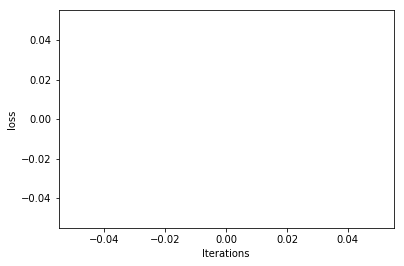

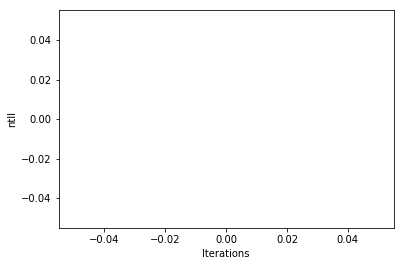

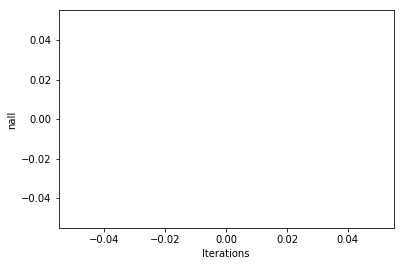

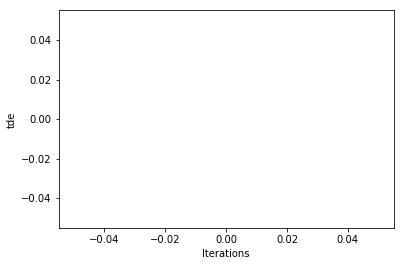

KeyboardInterrupt: 

In [19]:
frank_wolfe_train(sess, n_training_iters, nn_rollouts, train_idxes, batch_size, constraints, num_tasks, val_demo_batch,
                         states, adt_samples, MAX_ITER, STOP_CRIT)

## Testing Training Results

In [ ]:
# Sample full dynamics model
adt_probs = sess.run([adt_pred_dir], feed_dict={demo_tile_t_ph:adt_samples[:,0][np.newaxis].T,
                                                demo_act_t_ph:adt_samples[:,1][np.newaxis].T})[0]

In [61]:
# Print learned dynamics
softmax(adt_probs)

array([[0.21851705, 0.21590814, 0.16700909, 0.15032528, 0.24824043],
       [0.12729968, 0.1932118 , 0.1809985 , 0.1537752 , 0.3447148 ],
       [0.09719018, 0.15032631, 0.16841704, 0.1407823 , 0.44328415],
       [0.07598732, 0.11486345, 0.1437389 , 0.11873735, 0.54667306],
       [0.06006168, 0.08776291, 0.11498598, 0.09259684, 0.6445926 ],
       [0.685676  , 0.12618755, 0.02050173, 0.03548481, 0.13214986],
       [0.58982426, 0.12849943, 0.02475517, 0.0442449 , 0.21267632],
       [0.47259033, 0.12424549, 0.0295788 , 0.05008642, 0.32349893],
       [0.3443318 , 0.11211058, 0.03288628, 0.05184946, 0.45882192],
       [0.2359081 , 0.09102884, 0.03271087, 0.04863232, 0.59171987]],
      dtype=float32)

In [62]:
# Sample full q-fn model
q_vals = sess.run([constraint_q_ts], feed_dict={constraint_obs_t_feats_ph:states})[0]
# q_vals = sess.run([demo_q_t], feed_dict={demo_obs_t_feats_ph:states})[0]

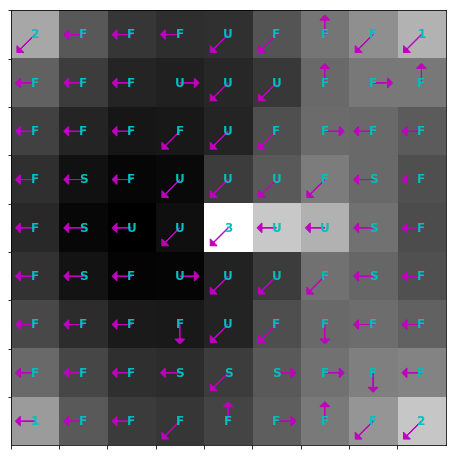

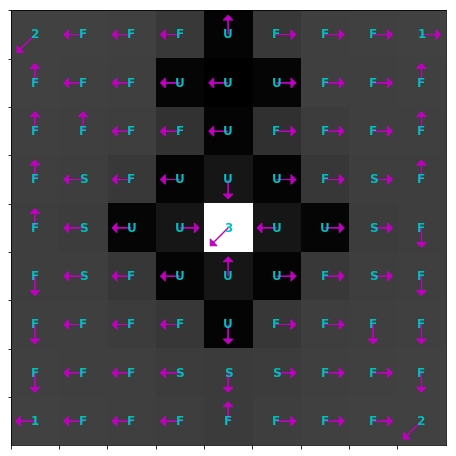

In [63]:
# Plot learned q-values and true q-values
plot_values(mdp, q_vals)
plot_values(mdp, Qs)

In [69]:
# More comprehensive debugging stuff

test_constraint_adt_pred_probs =  tf.placeholder(tf.float32, [None, n_dirs], name="tpp")
test_constraint_q_t_ph = tf.placeholder(tf.float32, [None], name="tcq")
test_constraint_q_tp1_ph = tf.placeholder(tf.float32, [None, n_dirs, n_act_dim], name="tcqp1")
test_constraint_v_tp1 = tf.reduce_logsumexp(test_constraint_q_tp1_ph, axis=2) #- np.log(5) 
test_adt_V = tf.multiply(test_constraint_v_tp1, test_constraint_adt_pred_probs)
test_adt_target = constraint_rew_t_ph + gamma * tf.reduce_sum(test_adt_V, axis=1)
indiv_errs = test_constraint_q_t_ph - test_adt_target
test_adt_td_err = tf.reduce_mean((test_constraint_q_t_ph - test_adt_target)**2)

In [71]:
# Q-fn Model Storage
q_net_path = os.path.join(data_dir, 'adt_true_q.tf')
save_tf_vars(sess, q_scope, q_net_path)

In [72]:
# Dynamics Model Storage
invadt_path = os.path.join(data_dir, 'adt_fw_t.tf')
save_tf_vars(sess, invadt_scope, invadt_path)

In [73]:
# Training data Storage
pkl.dump(mode_logs, open('adt_fw.pkl', 'wb'))